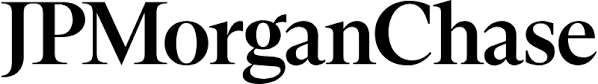

#**Task 1 : Interpolate and extrapolate the model to 1 year future**

##**1. Importing necessary library**


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline
np.random.seed(0)

##**2. Read data**


In [2]:
df = pd.read_csv('/content/drive/MyDrive/JPM_JOB_SIM/Nat_Gas (1).csv',index_col=0,parse_dates=True)
#original dataset has 48 months

/tmp/ipython-input-1894255436.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/drive/MyDrive/JPM_JOB_SIM/Nat_Gas (1).csv',index_col=0,parse_dates=True)


In [3]:
df.head(5)

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [4]:
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


##**3. Visualize (find patterns)**
See the seasonal trends, what factors affect it



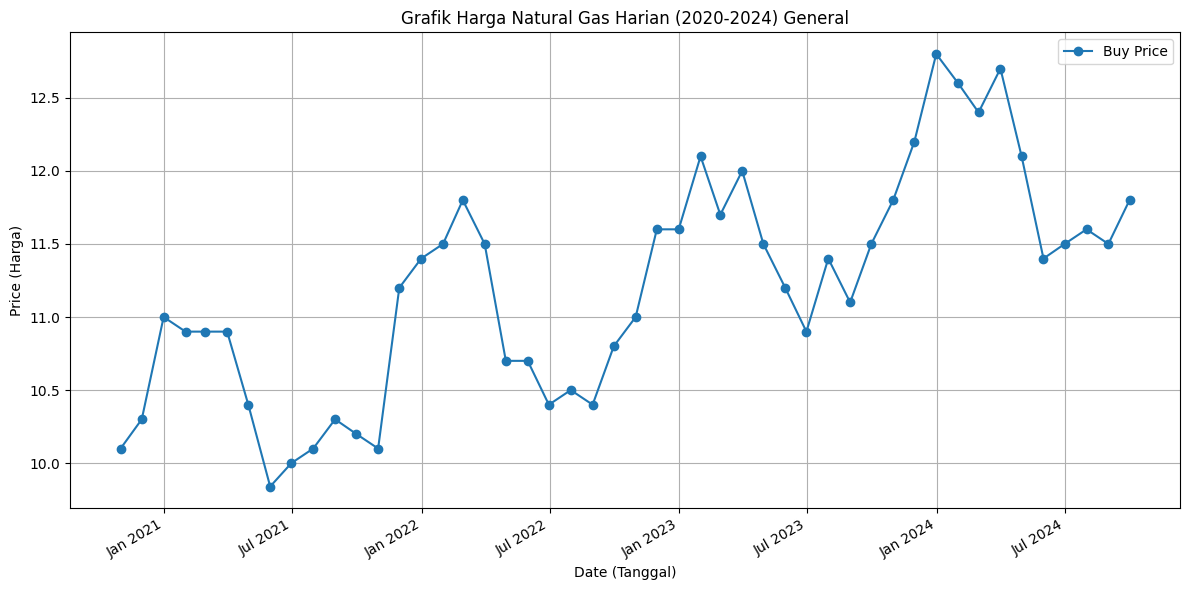

In [5]:
# Visualize before interpolation
plt.figure(figsize=(12, 6)) # Mengatur ukuran gambar agar lebih lebar dan mudah dibaca
plt.plot(df.index, df['Prices'],marker= 'o' , label='Buy Price')
plt.title('Grafik Harga Natural Gas Harian (2020-2024) General')
plt.xlabel('Date (Tanggal)') # Sumbu X seperti yang Anda minta
plt.ylabel('Price (Harga)') # Sumbu Y seperti yang Anda minta
plt.grid(True) # Menambahkan grid agar mudah dibaca
plt.legend()
ax = plt.gca() # Get Current Axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate() # Otomatis memiringkan label tanggal agar tidak tumpang tindih
plt.tight_layout() # Memastikan label tidak terpotong

In [6]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


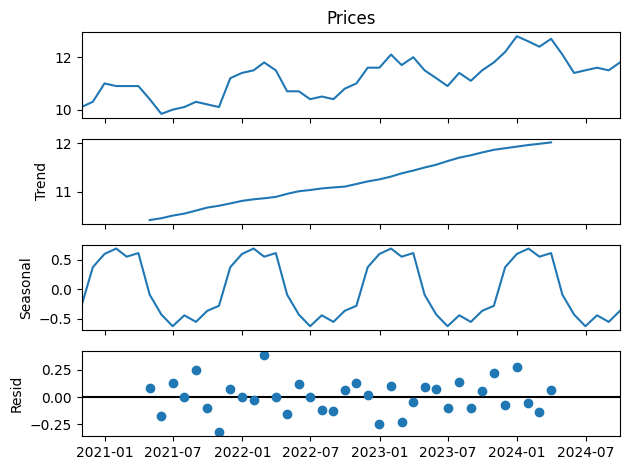

In [7]:
#Create decompose for identify trends, seasonal and residual
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Prices'], model='additive')
result = decomposition.plot()
plt.show()

Determine ADF and KPSS hypothesis(h0) and threshold = 0.05 (5%)
1.  ADF : hypothesis : this data is non stationer
2.  KPSS : hypothesis : this data is stationer
####What i search for the hypothesis : stationer or not


> If the p-value < 0.05 = refuse the hypothesis


> if the p-value > 0.05 = accepted the hypothesis


> **code below here :**




In [8]:
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test

adf_result = adfuller(df['Prices'])

adf_statistic, adf_p_value = adf_result[0], adf_result[1]

print(f"ADF Statistic: {adf_statistic}, p-value: {adf_p_value}")

# Perform KPSS test

kpss_result = kpss(df['Prices'], nlags='auto') # Automatically determines the number of lags

kpss_statistic, kpss_p_value = kpss_result[0], kpss_result[1]

print(f"KPSS Statistic: {kpss_statistic}, p-value: {kpss_p_value}")

if adf_p_value > 0.05 and kpss_p_value < 0.05 :
    print("conclusion : The data is non-stationary.")
else :
    print("conclusion : The data is stationary.")


ADF Statistic: 0.21807686169999427, p-value: 0.973257438844869
KPSS Statistic: 0.7304095231737717, p-value: 0.010780952438748024
conclusion : The data is non-stationary.


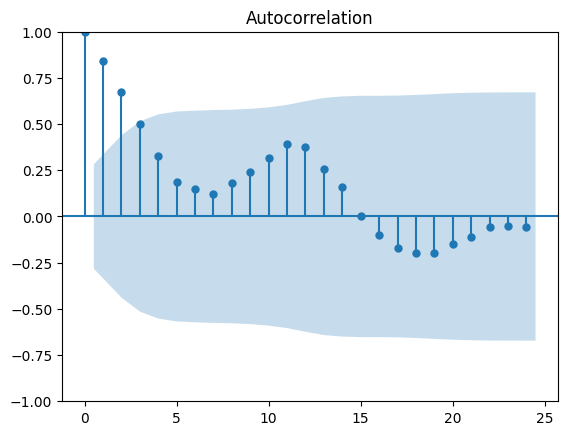

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=24)
plt.show()

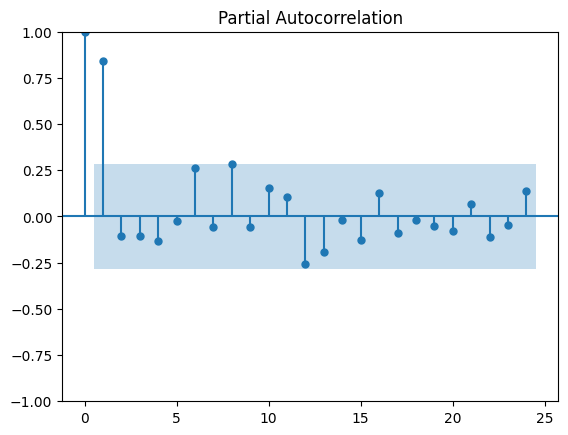

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df, lags=24, method = 'ywm')
plt.show()

Result from ACF and PACF Analysis is there is indication for yearly seasonality (every 12 months repeats the pattern), and today price is strongly correlated between 1,2,3,4 months before.   

##**4. Create interpolation using Cubic Spline**
Change per month to per date


In [11]:
x = df.index.astype('int').values # assign datetime ke timestamp agar bisa di kalkulasi oleh cubic spline
y = df['Prices'].values

In [12]:
# assign cubicspline algorithm
cs = CubicSpline(x,y)

In [13]:
#make daily date from df['Dates']
daily_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
print(daily_dates)

DatetimeIndex(['2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03',
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09',
               ...
               '2024-09-21', '2024-09-22', '2024-09-23', '2024-09-24',
               '2024-09-25', '2024-09-26', '2024-09-27', '2024-09-28',
               '2024-09-29', '2024-09-30'],
              dtype='datetime64[ns]', length=1431, freq='D')


In [14]:
#xc untuk column (date) yang sudah di pecah menjadi per hari dan udah di assign ke timestamp
#yc adalah prices yang akan dipake untuk interpolasi cubic spline
xc = daily_dates.astype('int').values # assign juga ke timestamp
yc = cs(xc)

In [15]:
#make new dataframe from cubic splined
dfc = pd.DataFrame({'Prices': yc}, index=xc)
#further analysis we will use dfc data

##**5. Modelling using SARIMA**
a. SARIMA is useful for analyzing and forecasting seasonal data ( non stationer)

b. SARIMA models incorporate non-seasonal and seasonal components for accurate time series forecasting.
Stationarity is crucial for SARIMA models, achieved through differencing to maintain constant statistical properties.
Parameter identification uses ACF and PACF plots to determine model components.
Diagnostic tests and AIC/BIC criteria ensure model adequacy and fit.
SARIMAX and hybrid models extend SARIMA for improved predictive accuracy and handling of exogenous variables.


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
np.random.seed(0)
# Fit a SARIMA model
def sarima_model(data, order, seasonal_order):
   try :
    model = SARIMAX(
            endog=data,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
    result = model.fit(disp=False)
    print(result.summary())
    return result

   except Exception as e :
    print("Model Error : ",e)

print("Before")
sarima_model(df['Prices'], order = (1,1,1), seasonal_order=(1,1,1,12)) #all p,q,d is set to 1, for initial-testing purpose

Before


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.581
Date:                            Sun, 16 Nov 2025   AIC                              6.838
Time:                                    14:39:38   BIC                             12.061
Sample:                                10-31-2020   HQIC                             7.972
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4532      0.301     -1.505      0.132      -1.044       0.137
ma.L1         -0.5152      0.344   

**Interpretation** : From reports above indicated that our SARIMA models is need to be tuned again. Important metrics to see is :
*   p >|z|
*   ar.L1, ma.L1, ar.S.L12, ma.S.L12 (is it important or no)'
*   AIC score (the lower the better than before)

So from here i need to differenced again (d=1) to remove the noise from seasonals pattern, and see what better "p" and "q" params outside of blue area. The goals from this differencing is to "cleaned" data from residuals to see better sight of p and q params


In [17]:
#differencing, see "cleaned" sight by removing seasonal and tren, to make it stationer

differenced_prices= df['Prices'].diff(1).diff(12)

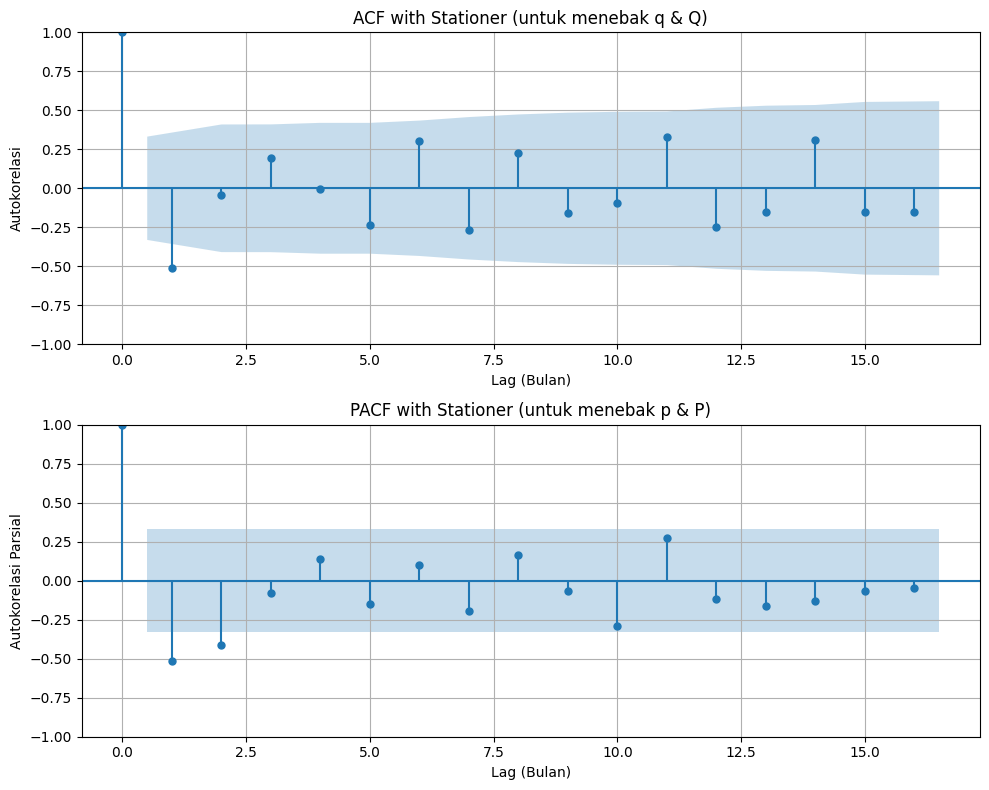

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax_acf, ax_pacf) = plt.subplots(2, 1, figsize=(10, 8))
lags = 16
#Plot ACF (untuk q da
plot_acf(differenced_prices.dropna(), lags=lags, ax=ax_acf)
ax_acf.set_title('ACF with Stationer (untuk menebak q & Q)')
ax_acf.set_xlabel('Lag (Bulan)')
ax_acf.set_ylabel('Autokorelasi')
ax_acf.grid(True)

# --- Plot PACF (untuk p dan P) ---
plot_pacf(differenced_prices.dropna(), lags=lags, method='ywm', ax=ax_pacf)
ax_pacf.set_title('PACF with Stationer (untuk menebak p & P)')
ax_pacf.set_xlabel('Lag (Bulan)')
ax_pacf.set_ylabel('Autokorelasi Parsial')
ax_pacf.grid(True)

plt.tight_layout()
plt.show()

Combination of p and q is : p (0) and q (1)
p and q is gotten from acf (q) and pacf(p). for acf we see what significant points turns to down (cut-off), that is at points-1. And for pacf we see if there is any significat setback until beyond the blue area with range time at 12 months, in this graph it doesn't, so we set the q to zero (0)


**let's re train our data**


In [19]:
print("After")
# order (p,d,q)
new_order = (0,1,1)
# seasonal_order (P,D,Q,S)
new_seasonal_order = (0,1,1,12)
test_result = sarima_model(df['Prices'], new_order, new_seasonal_order)
test_result

After
                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                   2.199
Date:                            Sun, 16 Nov 2025   AIC                              1.602
Time:                                    14:39:39   BIC                              4.735
Sample:                                10-31-2020   HQIC                             2.282
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7627      0.208     -3.668      0.000      -1.170      -0.355
ma.S.L12      -1.0002   1076.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


##**6. EVALUATING AND VALIDATION**

*   MAE: The mean absolute error (MAE) displays the average error between our predictions and the actual results.
*   RMSE: The root mean square error, or RMSE, indicates the size of the average forecast mistake.
*   Forecast Accuracy Percentage: This figure illustrates the accuracy with which our assumptions matched actual events.



In [20]:
#evaluating using timeseriessplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

rmse_scores = []
r2_scores = []
tscv = TimeSeriesSplit(n_splits=5, test_size = 6)
print(f"--- Memulai Time Series Cross-Validation (5 Lipatan) ---")

# --- 4. Loop Cross-Validation ---
# tscv.split(data) akan menghasilkan (train_index, test_index) untuk setiap lipatan
for fold, (train_index, test_index) in enumerate(tscv.split(df['Prices'])):
    print(f"\n--- Lipatan (Fold) {fold + 1} ---")

    # Ambil data berdasarkan index lipatan
    train_data = df['Prices'].iloc[train_index]
    test_data = df['Prices'].iloc[test_index]

    print(f"Ukuran Data Train: {len(train_data)} bulan")
    print(f"Ukuran Data Test:  {len(test_data)} bulan")

    # Latih model SARIMA HANYA pada data train
    model = SARIMAX(
        endog=train_data,
        order=new_order,
        seasonal_order=new_seasonal_order
    )
    # Kita .fit() modelnya di setiap loop (ini penting!)
    results = model.fit(disp=False)

    # Lakukan inference (ramalan)
    # Kita meramal sebanyak ukuran data tes
    forecast = results.get_forecast(steps=len(test_data))
    forecast_mean = forecast.predicted_mean

    # Hitung error (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
    r2 = r2_score(test_data, forecast_mean)
    print(f"RMSE Lipatan {fold + 1}: {rmse:.4f}")
    rmse_scores.append(rmse)
    r2_scores.append(r2)


# --- 5. Hasil Akhir ---
print("\n" + "="*50)
print("--- Hasil Cross-Validation Selesai ---")
print(f"Skor RMSE dari 5 Lipatan: {rmse_scores}")
print(f"Rata-rata RMSE (Jujur): {np.mean(rmse_scores):.4f}")
print(f"Rata-rata R SQRT: {np.mean(r2_scores):.4f}")
print(f"Std Dev RMSE (Stabilitas): {np.std(rmse_scores):.4f}")

--- Memulai Time Series Cross-Validation (5 Lipatan) ---

--- Lipatan (Fold) 1 ---
Ukuran Data Train: 18 bulan
Ukuran Data Test:  6 bulan


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE Lipatan 1: 0.2693

--- Lipatan (Fold) 2 ---
Ukuran Data Train: 24 bulan
Ukuran Data Test:  6 bulan


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE Lipatan 2: 0.3136

--- Lipatan (Fold) 3 ---
Ukuran Data Train: 30 bulan
Ukuran Data Test:  6 bulan


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE Lipatan 3: 0.2290

--- Lipatan (Fold) 4 ---
Ukuran Data Train: 36 bulan
Ukuran Data Test:  6 bulan


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE Lipatan 4: 0.2413

--- Lipatan (Fold) 5 ---
Ukuran Data Train: 42 bulan
Ukuran Data Test:  6 bulan


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE Lipatan 5: 0.2054

--- Hasil Cross-Validation Selesai ---
Skor RMSE dari 5 Lipatan: [np.float64(0.2692803835547944), np.float64(0.3136033994237699), np.float64(0.22904232477112832), np.float64(0.24126918528956073), np.float64(0.2053517166401192)]
Rata-rata RMSE (Jujur): 0.2517
Rata-rata R SQRT: -0.2104
Std Dev RMSE (Stabilitas): 0.0372


In [21]:
mon12_for=  model = SARIMAX(
        endog=df['Prices'],
        order=new_order,
        seasonal_order=new_seasonal_order
    )

run_mon12_for = mon12_for.fit(disp=False)
infer = run_mon12_for.get_forecast(steps=12)
infer_mean = infer.predicted_mean
print(type(infer_mean.index))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


##**7. Inferencing SARIMA Models**

In [22]:
low_up_bound = infer.conf_int(alpha=0.05)
low_up_bound

,lower Prices,upper Prices
2024-10-31,11.679154,12.528192
2024-11-30,12.254141,13.103195
2024-12-31,12.629133,13.478204
2025-01-31,12.704120,13.553208
2025-02-28,12.629096,13.478200
2025-03-31,12.704107,13.553228
2025-04-30,12.104100,12.953238
2025-05-31,11.714077,12.563232
2025-06-30,11.629072,12.478243
2025-07-31,11.829066,12.678254


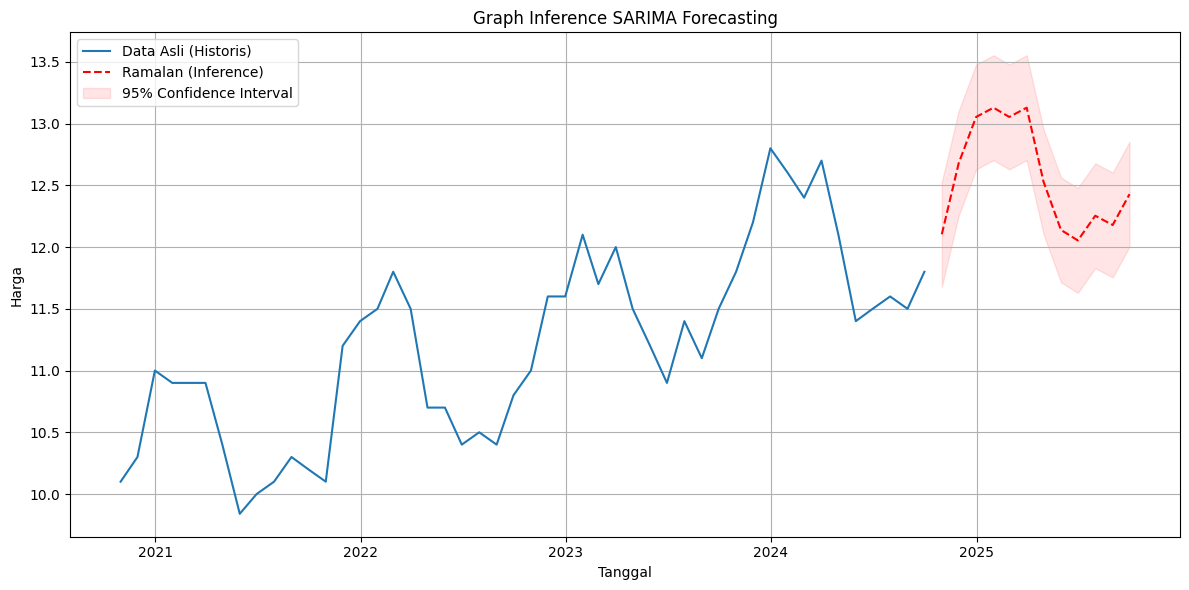

In [23]:
plt.figure(figsize=(12, 6))
# Plot data historis
plt.plot(df['Prices'], label='Data Asli (Historis)')
# Plot garis ramalan
plt.plot(infer_mean, label='Ramalan (Inference)', linestyle='--', color='red')

# Buat area Confidence Interval
plt.fill_between(
    low_up_bound.index,
    low_up_bound.iloc[:, 0], # lower
    low_up_bound.iloc[:, 1], # upper
    color='red',
    alpha=0.1,
    label='95% Confidence Interval'
)

plt.title('Graph Inference SARIMA Forecasting')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

##**8. Joining predicted to all data**


In [24]:
infer_mean.name = 'Prices'
joining = pd.concat([df['Prices'], infer_mean])
df_month = pd.DataFrame(joining, columns = ['Prices'])
df_month.index.name = 'Date'

In [25]:
df_month_clean = df_month.dropna()
len(df_month_clean)

60

In [26]:
print(f"panjang x itu  {len(df_month.index)} dan panjang y itu {len(df_month['Prices'])}")

panjang x itu  60 dan panjang y itu 60


###Using Spline


In [27]:
#make daily date from df['Dates']
daily_dates_2 = pd.date_range(start=df_month_clean.index.min(), end=df_month_clean.index.max(), freq='D')
print(daily_dates_2)

DatetimeIndex(['2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03',
               '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-07',
               '2020-11-08', '2020-11-09',
               ...
               '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24',
               '2025-09-25', '2025-09-26', '2025-09-27', '2025-09-28',
               '2025-09-29', '2025-09-30'],
              dtype='datetime64[ns]', length=1796, freq='D')


In [28]:
x_int = df_month_clean.index.astype('int').values # assign datetime ke timestamp agar bisa di kalkulasi oleh cubic spline
y_int = df_month_clean['Prices'].values

In [29]:
cs2 = CubicSpline(x_int,y_int)

In [30]:
#xc untuk column (date) yang sudah di pecah menjadi per hari dan udah di assign ke timestamp
#yc adalah prices yang akan dipake untuk interpolasi cubic spline
xc_2 = daily_dates_2.astype('int').values # assign juga ke timestamp
yc_2 = cs(xc_2)

In [31]:
#make new dataframe from cubic splined
dfc_2 = pd.DataFrame({'Prices': yc_2}, index=xc_2)
#further analysis we will use dfc data

In [32]:
dfc_2.index = pd.to_datetime(dfc_2.index)

In [33]:
dfc_2.index.name = 'Date'
dfc_2

,Prices
Date,
2020-10-31,10.100000
2020-11-01,10.079783
2020-11-02,10.062042
2020-11-03,10.046711
2020-11-04,10.033721
...,...
2025-09-26,303.549933
2025-09-27,305.710607
2025-09-28,307.881893


###Using pchip

In [34]:
#We use pchip implementation for solid and not overshoot interpolation
#use daily_dates_2 for the datetime index
#we create interpolation using original df_month
df_month.tail(5)

,Prices
Date,
2025-05-31,12.138655
2025-06-30,12.053658
2025-07-31,12.253660
2025-08-31,12.178650
2025-09-30,12.428661


In [35]:
#interpolate date for pchip
pchip_daily_index = pd.date_range(start=df_month.index.min(), end=df_month.index.max(), freq='D')

In [36]:
#reindex (filled with NA/NAN, so pchip can filled those NA/NAN value)
pchip_daily_reindex = df_month.reindex(pchip_daily_index)

In [37]:
df_pchip = pchip_daily_reindex.interpolate(method='pchip')
df_pchip.name = 'Prices-pchip'

In [38]:
df_pchip

,Prices
2020-10-31,10.100000
2020-11-01,10.100321
2020-11-02,10.101271
2020-11-03,10.102829
2020-11-04,10.104974
...,...
2025-09-26,12.375585
2025-09-27,12.388558
2025-09-28,12.401742
2025-09-29,12.415116


In [39]:
df_daily_final = df_pchip

In [40]:
df_daily_final.index.name='Date'
df_daily_final

,Prices
Date,
2020-10-31,10.100000
2020-11-01,10.100321
2020-11-02,10.101271
2020-11-03,10.102829
2020-11-04,10.104974
...,...
2025-09-26,12.375585
2025-09-27,12.388558
2025-09-28,12.401742


###Pchip vs spline interpolation graph

--- Membuat Plot Perbandingan Pchip vs Cubic ---


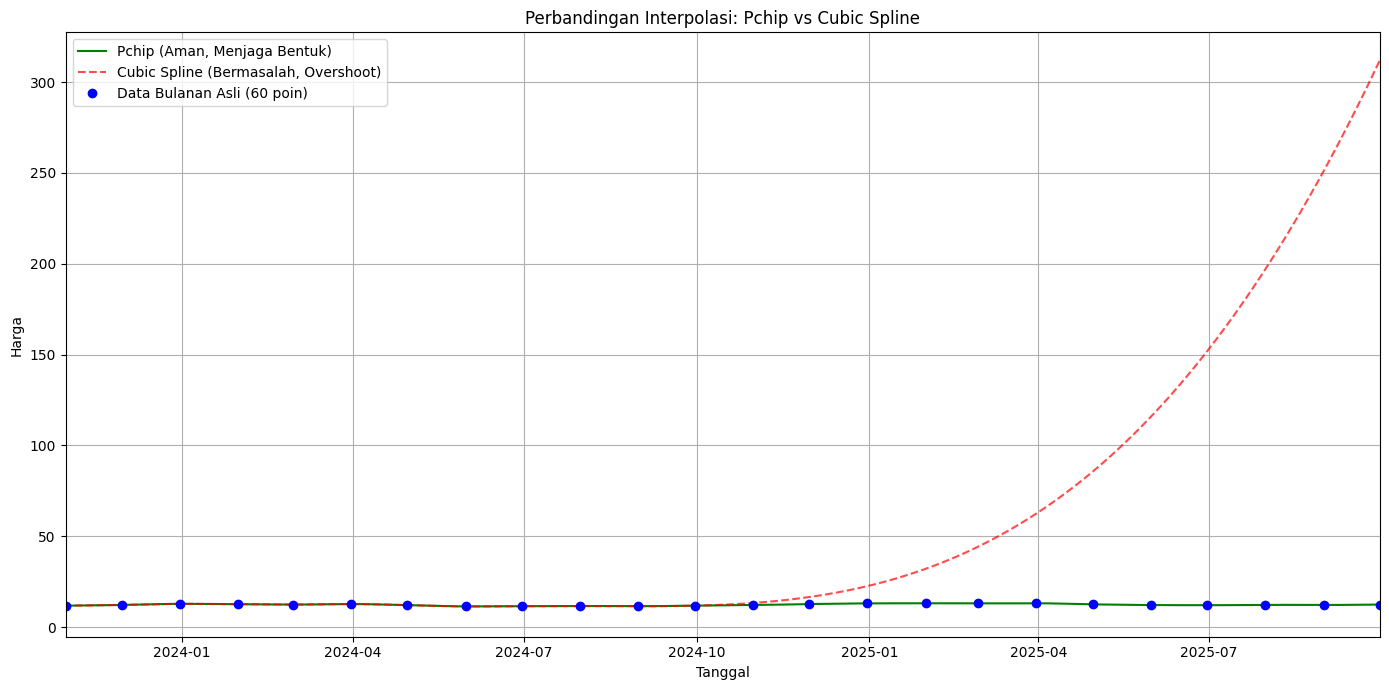

In [41]:
print("--- Membuat Plot Perbandingan Pchip vs Cubic ---")
plt.figure(figsize=(14, 7))

# Plot hasil Pchip (hijau, aman)
plt.plot(df_pchip.index, df_pchip, label='Pchip (Aman, Menjaga Bentuk)', color='green')

# Plot hasil Cubic (merah, overshoot)
plt.plot(dfc_2.index, dfc_2, label='Cubic Spline (Bermasalah, Overshoot)',
         linestyle='--', color='red', alpha=0.7)

# Plot titik data bulanan asli (agar terlihat jelas)
plt.plot(df_month.index, df_month, 'o',
         color='blue', label='Data Bulanan Asli (60 poin)')

# Kita zoom ke 24 bulan terakhir (di mana masalahnya terjadi)
plt.xlim(df_month.index[36], df_month.index[-1])
plt.title('Perbandingan Interpolasi: Pchip vs Cubic Spline')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()

##**9. Get 1 year prediction (input-output)**


In [42]:
# # Simpan tanggal min/max untuk pesan error
# min_date = df_daily_final.index.min()
# max_date = df_daily_final.index.max()

# print("Natural Gas 1 year buy prices daily prediction")
# print(f"Jangkauan data: {min_date.strftime('%Y-%m-%d')} s/d {max_date.strftime('%Y-%m-%d')}\n")

# def get_price (input_date : str):
#       query_date = pd.to_datetime(input_date)
#       price = df_daily_final.loc[query_date, 'Prices']
#       print(f"Harga yang diestimasi untuk {query_date.strftime('%Y-%m-%d')} adalah: ${price:.4f}")
#       return price

# input_user = input("Masukkan tanggal dalam string(YYYY-MM-DD) : ")
# get_price (input_user)

#**Task 2 : Modelling the deal price (injection and withdraw) for client**

Trade aggreement = price sell - price buy

Service cost (fixed cost)  :
1.   storage facillity maintanance = 100k / mon
2.   pay storage owner = 10% of trade agreement
3.   transport bill = 100k

**Final Trade Contract** : (Trade Agreement) - (SUM(Service Cost))







> flow system of inject-withdraw prototype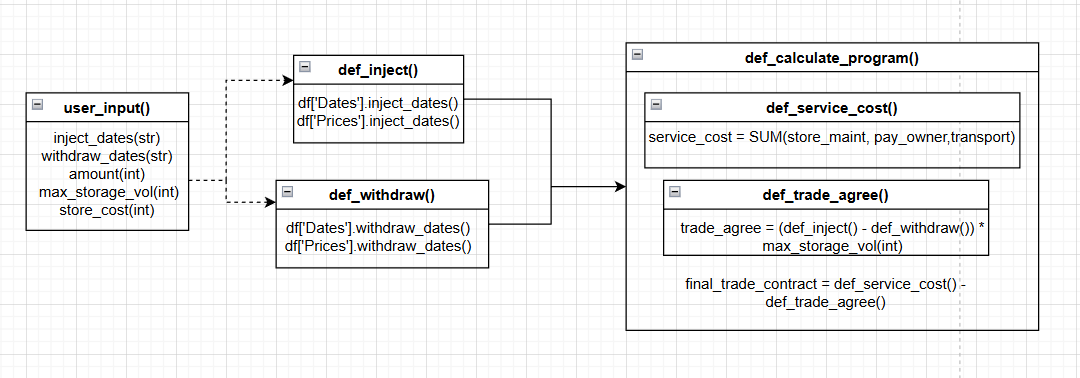



In [43]:
#SERVICE COST
STORE_MAINTANANCE = 100000
PAY_STORAGE_OWNER = 0.01 # of trade agreement
TRANS_BILL = 100000
#DATA PREP
DATA = pd.read_csv('/content/drive/MyDrive/JPM_JOB_SIM/output.csv',index_col=0,parse_dates=True)
MIN_DATE = DATA.index.min()
MAX_DATE = DATA.index.max()


In [44]:
def inject_dates (input_inject : str) :
  query_inject = pd.to_datetime(input_inject).strftime('%Y-%m-%d')
  return query_inject
def withdraw_dates (input_withdraw :str) :
  query_withdraw = pd.to_datetime(input_withdraw).strftime('%Y-%m-%d')
  return query_withdraw

def user_input() -> list :
  report = []
  print(f'program prototype for user buy-sell')
  print (f'range date {MIN_DATE.strftime('%Y-%m-%d')} - {MAX_DATE.strftime('%Y-%m-%d')}')
  trade_loops = int(input('How many you want trade (inject and withdraw) for this time : '))
  for i in range (trade_loops) :
    input_inject = input(f'loop : {i+1} for inject,  Enter the inject date (YYYY-MM-DD) : ')
    input_withdraw =input(f'loop : {i+1} for inject,  Enter the inject date (YYYY-MM-DD) : ')
    max_storage = int(input('Enter the max storage : '))
    report_user_input = {
    'inject_dates' : inject_dates(input_inject),
    'withdraw_dates' : withdraw_dates(input_withdraw),
    'max_storage' : max_storage,
    }

    report.append(report_user_input)
  return report

print("user input : ")
final_report_user_input = user_input()
print(final_report_user_input)


user input : 
program prototype for user buy-sell
range date 2020-10-31 - 2025-09-30
How many you want trade (inject and withdraw) for this time : 2
loop : 1 for inject,  Enter the inject date (YYYY-MM-DD) : 2021-1-1
loop : 1 for inject,  Enter the inject date (YYYY-MM-DD) : 2023-12-10
Enter the max storage : 40000000
Enter the storage cost : 300000
loop : 2 for inject,  Enter the inject date (YYYY-MM-DD) : 2023-1-1
loop : 2 for inject,  Enter the inject date (YYYY-MM-DD) : 2025-4-1
Enter the max storage : 5000000
Enter the storage cost : 40000
[{'inject_dates': '2021-01-01', 'withdraw_dates': '2023-12-10', 'max_storage': 40000000, 'storage_cost': 300000}, {'inject_dates': '2023-01-01', 'withdraw_dates': '2025-04-01', 'max_storage': 5000000, 'storage_cost': 40000}]


In [46]:
get_inject_dates = [injectdates['inject_dates'] for injectdates in final_report_user_input]
get_withdraw_dates = [withdrawdates['withdraw_dates'] for withdrawdates in final_report_user_input]
get_max_storage = [maxstorage['max_storage'] for maxstorage in final_report_user_input]

In [47]:
def inject_date_price (get_inject_dates : list) :
  get_inject_prices = []
  for i_date_str in get_inject_dates :
    change_datetime_inject = pd.to_datetime(i_date_str)
    if change_datetime_inject in DATA.index:
      get_price_inject = DATA.loc[change_datetime_inject, 'Prices']
      get_inject_prices.append(round(get_price_inject.item(),2))
    else:
      print(f"Warning: Injection date {i_date_str} not found in historical data. Skipping price retrieval for this date.")
  return get_inject_prices

def withdraw_date_price (get_withdraw_dates : list)  :
  get_withdraw_prices = []
  for w_date_str in get_withdraw_dates :
    change_datetime_withdraw = pd.to_datetime(w_date_str)
    if change_datetime_withdraw in DATA.index:
      get_price_withdraw = DATA.loc[change_datetime_withdraw, 'Prices']
      get_withdraw_prices.append(round(get_price_withdraw.item(),2))
    else:
      print(f"Warning: Withdrawal date {w_date_str} not found in historical data. Skipping price retrieval for this date.")
  return get_withdraw_prices

get_inject_price = inject_date_price(get_inject_dates)
get_withdraw_price = withdraw_date_price(get_withdraw_dates)
print(print(f"all withdraw prices here : {get_withdraw_price}"))
print(print(f"all inject prices here : {get_inject_price}"))

all withdraw prices here : [12.42, 13.13]
None
all inject prices here : [11.0, 11.6]
None


make list of dict to collect all reports for trade agreement preparation

function used :

get_inject_dates

get_withdraw_dates  

get_max_storage  

In [48]:
get_inject_dates

['2021-01-01', '2023-01-01']

In [49]:
get_withdraw_dates

['2023-12-10', '2025-04-01']

In [50]:
get_max_storage

[40000000, 5000000]

In [99]:
get_inject_price

[11.0, 11.6]

In [52]:
get_withdraw_price

[12.42, 13.13]

In [63]:
def trade_agreement_report_preparation (get_inject_dates,get_withdraw_dates,get_max_storage,get_inject_price,get_withdraw_price) :
  trade_agreement_report = []
  for i in range (len(final_report_user_input)) :
    dictionary_structure = {
        'Inject' : [get_inject_dates[i], get_inject_price[i]],
        'Withdraw' : [get_withdraw_dates[i], get_withdraw_price[i]],
        'Max Storage' : float(get_max_storage[i])
    }
    trade_agreement_report.append(dictionary_structure)
  return trade_agreement_report
trade_agreement_report = trade_agreement_report_preparation(get_inject_dates, get_withdraw_dates, get_max_storage, get_inject_price, get_withdraw_price)


In [64]:
trade_agreement_report = trade_agreement_report_preparation(get_inject_dates, get_withdraw_dates, get_max_storage, get_inject_price, get_withdraw_price)

In [107]:
trade_agreement_report

[{'Inject': ['2021-01-01', 11.0],
  'Withdraw': ['2023-12-10', 12.42],
  'Max Storage': 40000000.0},
 {'Inject': ['2023-01-01', 11.6],
  'Withdraw': ['2025-04-01', 13.13],
  'Max Storage': 5000000.0}]

In [62]:
type(trade_agreement_report[1]['Max Storage'])

int

In [92]:
for i in range (len(trade_agreement_report)) :
  print(i)

0
1


In [109]:
#calculate every loops of date
def final_trade_contract () :
  final_trade_contract_total = []
  for loops in range(len(trade_agreement_report)) :
    trade_agree = trade_agreement_report[loops]
    calculate_trade_agreement = round((trade_agree['Withdraw'][1] - trade_agree['Inject'][1]) * trade_agree['Max Storage'],2)
    clean_contract = calculate_trade_agreement - (STORE_MAINTANANCE + (PAY_STORAGE_OWNER * calculate_trade_agreement)+TRANS_BILL)
    final_trade_contract_total.append(clean_contract)
  return final_trade_contract_total


final_trade_agreement = final_trade_contract()
final_trade_agreement

[56032000.0, 7373500.0]

So now i got all the information, time to run on main function

In [114]:
def prototype_pricing_model () :
  final = {
      'User Input' : user_input(),
      'Inject Date Price' : inject_date_price(get_inject_dates),
      'Withdraw Date Price' : withdraw_date_price(get_withdraw_dates),
      'Trade Agreement Report' : trade_agreement_report,
      'Final Trade Contract' : final_trade_agreement
  }

  return final


run_modelling = prototype_pricing_model()
run_modelling


program prototype for user buy-sell
range date 2020-10-31 - 2025-09-30
How many you want trade (inject and withdraw) for this time : 2
loop : 1 for inject,  Enter the inject date (YYYY-MM-DD) : 2021-1-1
loop : 1 for inject,  Enter the inject date (YYYY-MM-DD) : 2023-1-1
Enter the max storage : 1000000
Enter the storage cost : 500
loop : 2 for inject,  Enter the inject date (YYYY-MM-DD) : 2023-12-1
loop : 2 for inject,  Enter the inject date (YYYY-MM-DD) : 2025-1-1
Enter the max storage : 2000000
Enter the storage cost : 300


{'User Input': [{'inject_dates': '2021-01-01',
   'withdraw_dates': '2023-01-01',
   'max_storage': 1000000,
   'storage_cost': 500},
  {'inject_dates': '2023-12-01',
   'withdraw_dates': '2025-01-01',
   'max_storage': 2000000,
   'storage_cost': 300}],
 'Inject Date Price': [11.0, 11.6],
 'Withdraw Date Price': [12.42, 13.13],
 'Trade Agreement Report': [{'Inject': ['2021-01-01', 11.0],
   'Withdraw': ['2023-12-10', 12.42],
   'Max Storage': 40000000.0},
  {'Inject': ['2023-01-01', 11.6],
   'Withdraw': ['2025-04-01', 13.13],
   'Max Storage': 5000000.0}],
 'Final Trade Contract': [56032000.0, 7373500.0]}